In [1]:
import albumentations as albu
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from image_segmentation.common import PROJECT_ROOT, DATA_LOADER_SEED
from image_segmentation.data.utils import Augment, load_test_images, load_train_valid_images
from image_segmentation.data.datamodule import DataModule
from image_segmentation.models.models import get_compiled_model
import tensorflow as tf
from imutils import paths
from typing import Tuple, Sequence
import random

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

import cv2
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

from image_segmentation.models.tf_unet.unet import unet_constructor

In [2]:
img_path = os.path.join(PROJECT_ROOT, 'data/membrane', 'train/image/0.png')
mask_path = os.path.join(PROJECT_ROOT, 'data/membrane', 'train/label/0.png')
data_path = [img_path, mask_path]


In [3]:
img, mask = load_train_valid_images(data_path=data_path)

In [4]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [5]:
print(img.shape, mask.shape)

(512, 512, 1) (512, 512, 1)


In [6]:
original_height, original_width = img.shape[:2]

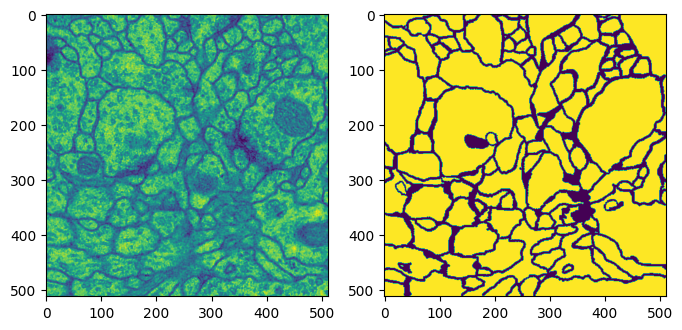

In [7]:
visualize(img, mask)

In [8]:
initialize(version_base=None, config_path="../conf", job_name="test_app")

hydra.initialize()

In [9]:
cfg = compose(config_name="default.yaml")

In [10]:
datamodule = hydra.utils.instantiate(cfg.nn.data, _recursive_=False)
datamodule.prepare_data()

In [11]:
datamodule.setup()

In [12]:
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

In [13]:
height = cfg.nn.data.resize.height
width = cfg.nn.data.resize.width

unet_config = cfg.nn.unet.structure
blocks_config = cfg.nn.unet.blocks
unet_model = unet_constructor(image_size=(height, width), blocks_config=blocks_config, **unet_config)

In [14]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 standard_block (StandardBlock)  (None, 256, 256, 64  640        ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 standard_block_1 (StandardBloc  (None, 256, 256, 64  36928      ['standard_block[0][0]']         
 k)                             )                                                              

In [15]:
# unet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

unet_model = get_compiled_model(
        model=unet_model,
        optimizer_config=cfg.nn.module.optimizer,
        custom_loss_config=cfg.nn.module.custom_loss,
        metrics_config=cfg.nn.module.metrics,
    )



In [16]:
unet_model

In [17]:
# model.predict_generator(testGene,30,verbose=1)

In [18]:
unet_model.fit_generator(train_dataloader, epochs=5, validation_data=val_dataloader)

/tmp/ipykernel_13030/2312363827.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  unet_model.fit_generator(train_dataloader, epochs=5, validation_data=val_dataloader)


Epoch 1/5
12/12 [==============================] - 58s 5s/step - loss: 0.6977 - categorical_accuracy: 1.0000 - categorical_crossentropy: 9.3508e-08 - val_loss: 0.6896 - val_categorical_accuracy: 1.0000 - val_categorical_crossentropy: 9.5182e-08
Epoch 2/5


: 

: 

In [ ]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
# # Instantiate a loss function.
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# epochs = 2

In [ ]:
# for x, y in train_dataloader:
#     with tf.GradientTape() as tape:
#         logits = unet_model(x)
#         print(logits.shape)
#     break

In [ ]:
# for step, (x_batch_train, y_batch_train) in enumerate(train_dataloader):
#     print(x_batch_train.shape, y_batch_train.shape)

#     with tf.GradientTape() as tape:

#             # Run the forward pass of the layer.
#             # The operations that the layer applies
#             # to its inputs are going to be recorded
#             # on the GradientTape.
#             logits = unet_model(x_batch_train, training=True)

#             print(logits.shape)
#     break

In [ ]:
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))

#     # Iterate over the batches of the dataset.
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataloader):

#         # Open a GradientTape to record the operations run
#         # during the forward pass, which enables auto-differentiation.
#         with tf.GradientTape() as tape:

#             # Run the forward pass of the layer.
#             # The operations that the layer applies
#             # to its inputs are going to be recorded
#             # on the GradientTape.
#             logits = unet_model(x_batch_train, training=True)  # Logits for this minibatch

#             # Compute the loss value for this minibatch.
#             loss_value = loss_fn(y_batch_train, logits)

#         # Use the gradient tape to automatically retrieve
#         # the gradients of the trainable variables with respect to the loss.
#         grads = tape.gradient(loss_value, unet_model.trainable_weights)

#         # Run one step of gradient descent by updating
#         # the value of the variables to minimize the loss.
#         optimizer.apply_gradients(zip(grads, unet_model.trainable_weights))

#         # Log every 200 batches.
#         if step % 200 == 0:
#             print(
#                 "Training loss (for one batch) at step %d: %.4f"
#                 % (step, float(loss_value))
#             )
#             print("Seen so far: %s samples" % ((step + 1) * 2))